In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(9991, 28)
(9991, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
X_relative_footsteps_acc[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [8]:
## Entries where FL is swinging
idxs = np.where(X_relative_footsteps_acc[:, 21] == 1)[0]
X_relative_footsteps_acc_FL_swinging = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_FL_swinging = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [9]:
X_relative_footsteps_acc_FL_swinging.shape

(4999, 28)

In [10]:
#X_relative_footsteps_acc_FL_swinging[:10, :]

In [11]:
Y_relative_footsteps_acc_FL_swinging[0, :]

array([ 0.22407743,  0.18885393,  0.23964177, -0.19926585, -0.26746292,
        0.12131841, -0.25399354, -0.15574807])

### Linear Regression

In [115]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_swinging[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_swinging[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

best_model = None
highest_r2_score = 0.0
lowest_error = 1000

# Create the model
model_fl_relative_support_x = LinearRegression()

for _ in range(10000):
    # Split data into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

    # Fit the model
    model_fl_relative_support_x.fit(X_train, Y_train)
    
    # Predict
    predictions = model_fl_relative_support_x.predict(X_test)
    
    if r2_score(predictions, Y_test) > highest_r2_score:
        best_model = model_fl_relative_support_x
        highest_r2_score = r2_score(predictions, Y_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8873716099443656
RMSE:  0.010437300913986954
The lowest error is:  6.647152481581431e-06
The highest error is:  0.08027291752943433
The avg. error is:  0.00573050670001728


In [116]:
model_fl_relative_support_x.coef_

array([[-0.01703928,  0.01609551, -0.04254703,  0.10599798,  0.00264294,
        -0.04259171,  0.63166733,  0.04994194, -0.44223554, -0.05830288,
         0.58786427, -0.10639846, -0.48353674, -0.21883149]])

In [117]:
model_fl_relative_support_x.intercept_

array([0.17541917])

Text(0, 0.5, 'Predictions')

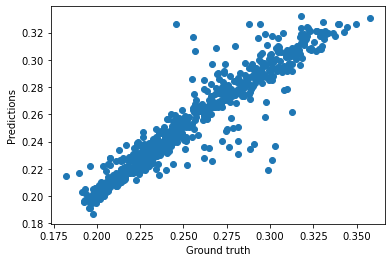

In [118]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#%store model_fl_relative_support_x

In [23]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [24]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [120]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_swinging[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_swinging[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_swinging[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9461962506129814
RMSE:  0.005227051167482011
The lowest error is:  3.1601251026247557e-06
The highest error is:  0.04816981165849135
The avg. error is:  0.002813507983779008


In [121]:
model_fl_relative_support_y.coef_

array([[ 8.12269578e-03, -4.76045577e-03, -1.69002686e-02,
         4.69447911e-04,  1.03681944e-01,  3.32498926e-02,
         1.07024308e-01,  5.31917355e-01,  5.48521613e-03,
         2.40008829e-01, -6.67322679e-02, -3.82445142e-02,
        -9.18447123e-02, -2.59732341e-02]])

In [122]:
model_fl_relative_support_y.intercept_

array([0.05695342])

Text(0, 0.5, 'Predictions')

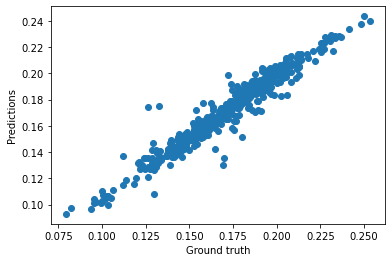

In [123]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [56]:
#%store model_fl_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")